In [427]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [428]:

#datasets 
src_vocab = {"<pad>": 0, "<eos>": 1, "<unk>": 2, "How": 3, "are": 4, "you": 5, "?": 6}
tgt_vocab = {"<pad>": 0, "<eos>": 1, "<unk>": 2, "Comment": 3, "allez-vous": 4, "?": 5}


src_sentence = ["How", "are", "you", "?"]
tgt_sentence = ["Comment", "allez-vous", "?"]

src_indices = [src_vocab[word] for word in src_sentence]
tgt_indices = [tgt_vocab[word] for word in tgt_sentence]

src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
embedding_dim = 64

src_embedding = nn.Embedding(src_vocab_size, embedding_dim)
tgt_embedding = nn.Embedding(tgt_vocab_size, embedding_dim)


src_indices_tensor = torch.tensor([src_indices], dtype=torch.long)  
tgt_indices_tensor = torch.tensor([tgt_indices], dtype=torch.long)

src_mask = (src_indices_tensor != src_vocab["<pad>"])
tgt_mask = (tgt_indices_tensor != tgt_vocab["<pad>"])

src_embeddings = src_embedding(src_indices_tensor)  
tgt_embeddings = tgt_embedding(tgt_indices_tensor) 

Q = src_embeddings 
K = tgt_embeddings 
V = tgt_embeddings 

if K.shape[1] < Q.shape[1]:
    pad_length = Q.shape[1] - K.shape[1]
    K = torch.nn.functional.pad(K, (0, 0, 0, pad_length))  
    V= torch.nn.functional.pad(V, (0, 0, 0, pad_length))  



In [429]:

class RLAttention(nn.Module):
    def __init__(self, model_dimension, n_heads):
        super(RLAttention, self).__init__()
        self.model_dimension = model_dimension
        self.n_heads = n_heads
        self.dimension = model_dimension // n_heads
        self.seq_length = K.size(1)

        self.q = nn.Linear(model_dimension, model_dimension)
        self.k = nn.Linear(model_dimension, model_dimension)
        self.v = nn.Linear(model_dimension, model_dimension)
        self.o = nn.Linear(model_dimension, model_dimension)
        self.layer_norm = nn.LayerNorm(model_dimension)

        self.policy_network = nn.Sequential(
            nn.Linear(self.dimension, 64),  
            nn.ReLU(),
            nn.Linear(64, self.seq_length),  
            nn.Softmax(dim=-1)  
        )


    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.q(Q))
        K = self.split_heads(self.k(K))
        V = self.split_heads(self.v(V))
        
        attention_weights = self.select_attention_weights(Q, K, mask)

        output = torch.matmul(attention_weights, V)
        combined = self.combine_heads(output)
        combined = self.layer_norm(combined)
        return self.o(combined), attention_weights
        
    def split_heads(self, x):
        batch_size, seq_length, model_dim = x.size()
        x = x.view(batch_size, seq_length, self.n_heads, self.dimension)
        return x.permute(0, 2, 1, 3) 
    def combine_heads(self, x):
        batch_size, n_heads, seq_length, dimension = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(batch_size, seq_length, n_heads * dimension)

    def select_attention_weights(self, Q, K, mask=None):
        batch_size, n_heads, seq_length_query, dimension = Q.size()
        _,_,seq_length_key, _ = K.size()

        # convert the queries to 1D for policy input
        Q_flat = Q.reshape(batch_size * n_heads * seq_length_query, dimension)
        
        action_probs = self.policy_network(Q_flat)
        
        action_probabilities = action_probs.view(batch_size, n_heads, seq_length_query, seq_length_key)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2) 
            action_probabilities = action_probabilities.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = torch.softmax(action_probabilities, dim=-1)

        return attention_weights

In [430]:
model = RLAttention(model_dimension=64, n_heads=8)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [431]:
def reward_function(predicted_translation, target_translation):
    cosine_sim = torch.cosine_similarity(predicted_translation, target_translation, dim=-1)
    predicted_len = predicted_translation.norm(p=2, dim=-1)
    target_len = target_translation.norm(p=2, dim=-1)
    length_normalized_sim = cosine_sim / (predicted_len * target_len + 1e-9)
    return length_normalized_sim.mean()


In [432]:
epochs = 5
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
epoch_list = []
loss_list = []
reward_list = []
#start time
start = time.time()
for epoch in range(epochs):
    epoch_list.append(epoch + 1)
    optimizer.zero_grad()
    
    # Forward pass
    output, attention_weights = model(Q, K, V, mask=src_mask)
    
    rewards = reward_function(output, src_embeddings)
    reward_list.append(rewards.item())
 
    log_probs = torch.log(attention_weights + 1e-9) 
    loss = -torch.sum(log_probs * rewards.unsqueeze(-1))
    loss_list.append(loss.item())
    
    loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 

    optimizer.step()
    scheduler.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

#end time
end = time.time()

print(f"Time taken: {end-start} seconds")

Epoch 1/5, Loss: 0.3262951970100403
Epoch 2/5, Loss: 0.0850018858909607
Epoch 3/5, Loss: -0.13785910606384277
Epoch 4/5, Loss: -0.34083524346351624
Epoch 5/5, Loss: -0.5285869836807251
Time taken: 0.008788108825683594 seconds


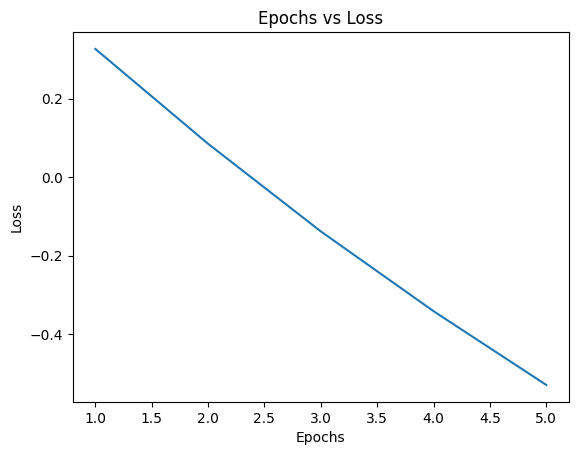

In [433]:
#plot the epochs vs loss
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.show()

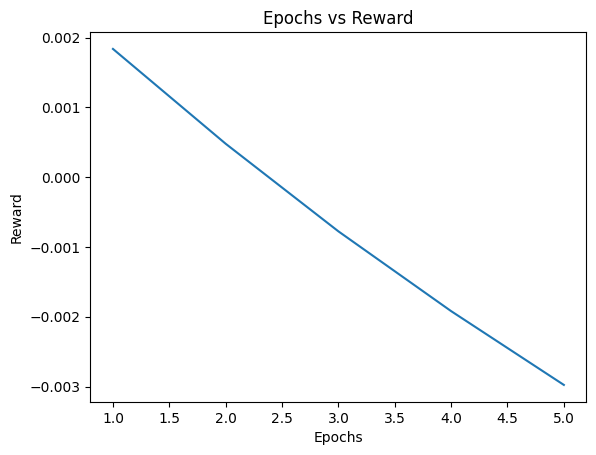

In [434]:
#plot the epochs vs reward
plt.plot(epoch_list, reward_list)
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.title('Epochs vs Reward')
plt.show()